In [1]:
import os, pickle, cloudpickle
import pandas as pd
import numpy as np
import shapely, shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import os.path as path


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# specify number of stations want to increase
NUM_STATIONS_INC = 1

In [3]:
# specify dir
CITY = "P_"
save_dir = CITY + 'res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')


In [4]:
# load unmitigated random forest
with open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb') as file:  
    rf_best = pickle.load(file)

# load exponentiated gradient
with open(os.path.join(save_dir_models, CITY + "exp_grad.pkl"), 'rb') as file:  
    eg_best = cloudpickle.load(file)

# load grid search
with open(os.path.join(save_dir_models, CITY + "grid_search.pkl"), 'rb') as file:  
    gs_best = pickle.load(file)

In [5]:
# load necessary datasets
df_pgh_census = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_pgh_census.csv"), index_col = 0)
df_weather = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_weather_final.csv"), index_col = 0)
X_train = pd.read_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"), index_col = 0)
df_geo = pd.read_csv(os.path.join(save_dir_forecast, CITY + "geo_df.csv"), index_col = 0)
for row,col in df_geo.iterrows():
    df_geo.at[row, 'geometry'] = shapely.wkt.loads(df_geo.loc[row]['geometry'])
df_station_cap = pd.read_csv(os.path.join(save_dir_forecast, CITY + "df_station_cap.csv"), index_col = 0)

### load walk score for others

In [6]:
df_walk_score = pd.read_csv("data/walkscoresAPI.csv", index_col = 0)
df_walk_score

,cell_num,walk_score,bike_score,transit_score,nearby
0,51,9,15,-1,NaN
1,52,3,8,22,"2 nearby routes: 2 bus, 0 rail, 0 other"
2,82,14,25,29,"3 nearby routes: 3 bus, 0 rail, 0 other"
3,83,12,40,27,"3 nearby routes: 3 bus, 0 rail, 0 other"
4,84,2,7,24,"2 nearby routes: 2 bus, 0 rail, 0 other"
...,...,...,...,...,...
723,1587,21,19,47,"22 nearby routes: 22 bus, 0 rail, 0 other"
724,1588,19,19,41,"14 nearby routes: 14 bus, 0 rail, 0 other"
725,1589,48,37,-1,NaN
726,1619,21,24,41,"16 nearby routes: 16 bus, 0 rail, 0 other"


In [7]:
# load two datasets
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['nearby']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['nearby']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["nearby"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

# censusTract

df_walk_score_temp = df_walk_score.groupby("cell_num").mean().reset_index()

for col in df_walk_score_temp.columns:
    df_walk_score_temp[col] = df_walk_score_temp[col].astype(int)
    
df_walk_score_temp.head()

,cell_num,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,51,9,15,-1,0,0,0,0
1,52,3,8,22,2,0,0,2
2,82,14,25,29,3,0,0,3
3,83,12,40,27,3,0,0,3
4,84,2,7,24,2,0,0,2


In [8]:
df_merge = df_pgh_census.merge(df_walk_score_temp, on = 'cell_num', how = "left")
df_merge

,cell_num,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,...,wfh,own_alone,carpool,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,51,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,9,15,-1,0,0,0,0
1,52,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,3,8,22,2,0,0,2
2,82,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,14,25,29,3,0,0,3
3,83,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,12,40,27,3,0,0,3
4,84,67409,2660,1306,23,1695,0.156342,0.037168,0.0,0.634586,...,58,1083,226,2,7,24,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,21,19,47,22,0,0,22
724,1588,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,19,19,41,14,0,0,14
725,1589,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,48,37,-1,0,0,0,0
726,1619,30089,2394,1391,26,1066,0.181051,0.000000,0.0,0.462824,...,179,581,113,21,24,41,16,0,0,16


In [9]:
df_all = df_merge.merge(df_station_cap, how = 'left', on = "cell_num").fillna(0)
df_all.stations = df_all.stations.astype(int)
df_all.capacity = df_all.capacity.astype(int)

In [10]:
# duplicate rows 
df_forc = pd.DataFrame(np.repeat(df_all.values, 12, axis=0))
df_forc.columns = df_all.columns

# load 2019 weather
df_weather_19 = df_weather[df_weather.year == 2019]

# attach weather & month
for index, col in df_forc.iterrows():
    curr_month = index%12 + 1
    
    df_forc.at[index, "month"] = curr_month
    df_forc.at[index, "temp"] = df_weather_19[df_weather_19.month == curr_month].temp.values[0]

df_forc.month = df_forc.month.astype(int)

# save cell_num
cell_num = df_forc["cell_num"]
df_forc.drop(columns = "cell_num", inplace = True)


In [11]:
# training set
df_forc["median_hh_income"] = df_forc["median_hh_income"].replace("-", 0)
df_forc.median_hh_income = df_forc.median_hh_income.astype(int)

int_col = ["population_16yrs+", "total_households", "mean_travel_time_to_work", "Workers_16yrs+", "wfh", 
          'own_alone', 'carpool', 'walk_score', 'bike_score', 'transit_score', 'nearby_bus', 
           'nearby_rail', 'nearby_other', 'nearby_routes', 'stations', 'capacity', 'month']
float_col = ['perc_public', 'perc_walk', 'perc_other', 'perc_employed', 'perc_unemployed', 'temp']

for col in int_col:
    df_forc[col] = df_forc[col].astype(int)

for col in float_col:
    df_forc[col] = df_forc[col].astype(float)


In [12]:
df_forc["income_group"] = 0

for row, col in df_forc.iterrows():
    
    if df_forc.loc[row]["median_hh_income"] > 50000:
        df_forc.at[row, "income_group"] = 1
        
df_forc.drop(columns = ["median_hh_income"], inplace = True)

# sns.countplot(">50K", data = df_forc)
# plt.title("Distribution of income")

In [13]:
# match order
df_forc = df_forc[X_train.columns]

In [14]:
X_train

,month,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,...,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool,income_group
0,7,73.5,1,10,76,82,86,58,3,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
1,8,73.0,1,10,76,82,86,58,3,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
2,9,69.7,1,10,76,82,86,58,3,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
3,10,53.4,1,10,76,82,86,58,3,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
4,11,37.3,1,10,76,82,86,58,3,2,...,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3270,8,73.0,1,8,72,86,62,27,0,0,...,1123,0.166518,0.017809,0.079252,0.655072,0.055072,79,645,103,1
3271,9,69.7,1,8,72,86,62,27,0,0,...,1123,0.166518,0.017809,0.079252,0.655072,0.055072,79,645,103,1
3272,10,53.4,1,8,72,86,62,27,0,0,...,1123,0.166518,0.017809,0.079252,0.655072,0.055072,79,645,103,1
3273,11,37.3,1,8,72,86,62,27,0,0,...,1123,0.166518,0.017809,0.079252,0.655072,0.055072,79,645,103,1


In [15]:
# # scale
# columns_new = list(df_forc.columns)
# columns_new.remove('income_group')

# min_max_scaler = preprocessing.MinMaxScaler()
# df_scaled = min_max_scaler.fit_transform(df_forc.drop(columns = ['income_group']))
# df_scaled = pd.DataFrame(df_scaled, columns = columns_new)

# df_scaled["income_group"] = df_forc["income_group"]
# # df_scaled["stations"] = df["stations"]
# # df_scaled.outflow = min_max_scaler.fit_transform(df_scaled.outflow.values.reshape(-1, 1))
# df_forc = df_scaled

### prediction

In [16]:
# ## old prediction
# old_pred_random_forest = rf_best.predict(df_forc)
# old_pred_exp_grad = eg_best.predict(df_forc, random_state = 42)
# old_pred_grid_search = gs_best.predict(df_forc)

In [17]:
# increase stations by NUM_STATIONS_INC, then scale
df_forc_new = df_forc.copy()
df_forc_new["stations"] += NUM_STATIONS_INC

In [18]:
## new prediction
new_pred_random_forest = rf_best.predict(df_forc_new)
new_pred_exp_grad = eg_best.predict(df_forc_new, random_state = 42)
new_pred_grid_search = gs_best.predict(df_forc_new)

In [19]:
pred_df = cell_num.to_frame()
pred_df["month"] = df_forc_new["month"]
pred_df["income_group"] = df_forc_new["income_group"]
# pred_df["stations_added"] = df_forc_new["stations"]

In [20]:
pred_df["stations_added"] = df_forc_new["stations"]
# pred_df[pred_df.stations_added > 0]

In [21]:
cell_num2stations_df = pred_df.groupby("cell_num").mean().reset_index()[["cell_num", "stations_added"]]
# cell_num2stations_df.stations_added = cell_num2stations_df.stations_added.astype(int)
cell_num2stations_df

,cell_num,stations_added
0,51,1.0
1,52,1.0
2,82,1.0
3,83,1.0
4,84,1.0
...,...,...
723,1587,1.0
724,1588,1.0
725,1589,1.0
726,1619,1.0


In [22]:
# pred_df["old_pred_random_forest"] = old_pred_random_forest
# pred_df["old_pred_exp_grad"] = old_pred_exp_grad
# pred_df["old_pred_grid_search"] = old_pred_grid_search

pred_df["new_pred_random_forest"] = new_pred_random_forest
pred_df["new_pred_exp_grad"] = new_pred_exp_grad
pred_df["new_pred_grid_search"] = new_pred_grid_search

# pred_df["random_forest_pred_diff"] = new_pred_random_forest - old_pred_random_forest
# pred_df["exp_grad_pred_diff"] = new_pred_exp_grad - old_pred_exp_grad
# pred_df["grid_search_pred_diff"] = new_pred_grid_search - old_pred_grid_search

In [23]:
pred_df.new_pred_random_forest.sum()

504012.28130840056

In [24]:
# sum over months
# attach # of stations info
pred_df_yearly = pred_df.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
pred_df_yearly["income_group"] = pred_df_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
pred_df_yearly = pred_df_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
pred_df_yearly = pred_df_yearly.merge(df_geo, on = "cell_num")
pred_df_yearly = gpd.GeoDataFrame(pred_df_yearly, crs='EPSG:2956', geometry='geometry')
pred_df_yearly

,cell_num,income_group,stations_added_x,new_pred_random_forest,new_pred_exp_grad,new_pred_grid_search,stations_added_y,geometry,centroid
0,51,high_income,12,699.955953,900.652722,737.886748,1.0,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194)
1,52,high_income,12,699.955953,900.652722,737.886748,1.0,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908)
2,82,high_income,12,699.955953,900.652722,737.886748,1.0,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479)
3,83,high_income,12,699.955953,900.652722,737.886748,1.0,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194)
4,84,high_income,12,699.955953,900.652722,737.886748,1.0,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908)
...,...,...,...,...,...,...,...,...,...
723,1587,low_income,12,653.922881,865.781511,763.716630,1.0,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194)
724,1588,low_income,12,639.782881,880.374738,772.183305,1.0,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908)
725,1589,low_income,12,639.782881,888.189738,760.808305,1.0,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623)
726,1619,low_income,12,639.782881,862.997119,772.183305,1.0,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194)


In [25]:
# pred_random_forest = pred_df[pred_df.random_forest_pred_diff > 0]
# pred_random_forest = pred_random_forest[["cell_num", "month", "income_group", "old_pred_random_forest", "new_pred_random_forest", "random_forest_pred_diff"]]

# pred_exp_grad = pred_df[pred_df.exp_grad_pred_diff > 0]
# pred_exp_grad = pred_exp_grad[["cell_num", "month", "income_group", "old_pred_exp_grad", "new_pred_exp_grad", "exp_grad_pred_diff"]]

# pred_grid_search = pred_df[pred_df.grid_search_pred_diff > 0]
# pred_grid_search = pred_grid_search[["cell_num", "month", "income_group", "old_pred_grid_search", "new_pred_grid_search", "grid_search_pred_diff"]]


In [26]:
# # sum over months
# pred_random_forest_yearly = pred_random_forest.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_random_forest_yearly["bi_income"] = pred_random_forest_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_random_forest_yearly.drop(columns = ["income_group"], inplace = True)

# pred_exp_grad_yearly = pred_exp_grad.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_exp_grad_yearly["bi_income"] = pred_exp_grad_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_exp_grad_yearly.drop(columns = ["income_group"], inplace = True)

# pred_grid_search_yearly = pred_grid_search.groupby("cell_num").sum().reset_index().drop(columns = ["month"])
# pred_grid_search_yearly["bi_income"] = pred_grid_search_yearly["income_group"].apply(lambda x: "high_income" if x > 0 else "low_income")
# pred_grid_search_yearly.drop(columns = ["income_group"], inplace = True)

In [27]:
# # attach # of stations info
# pred_random_forest_yearly = pred_random_forest_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_exp_grad_yearly = pred_exp_grad_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')
# pred_grid_search_yearly = pred_grid_search_yearly.merge(cell_num2stations_df, on = "cell_num", how = 'left')

### analysis 1: visualize

In [28]:
# pred_random_forest_geo = pred_random_forest_yearly.merge(df_geo, on = "cell_num", how = "right")
# pred_exp_grad_geo = pred_exp_grad_yearly.merge(df_geo, on = "cell_num", how = "right")
# pred_grid_search_geo = pred_grid_search_yearly.merge(df_geo, on = "cell_num", how = "right")

# pred_random_forest_geo = gpd.GeoDataFrame(pred_random_forest_geo, crs='EPSG:2956', geometry='geometry')
# pred_exp_grad_geo = gpd.GeoDataFrame(pred_exp_grad_geo, crs='EPSG:2956', geometry='geometry')
# pred_grid_search_geo = gpd.GeoDataFrame(pred_grid_search_geo, crs='EPSG:2956', geometry='geometry')

In [29]:
# pred_random_forest_geo = pred_random_forest_geo.fillna(0)
# pred_exp_grad_geo = pred_exp_grad_geo.fillna(0)
# pred_grid_search_geo = pred_grid_search_geo.fillna(0)

In [30]:
# # plot one by one
# # type(pgh_grid_income.loc[0]['geometry'])
# # for row, col in pred_random_forest_geo.iterrows():
# #     pred_random_forest_geo.at[row, 'geometry'] = shapely.wkt.loads(pred_random_forest_geo.loc[row]['geometry'])

# pred_random_forest_geo.plot(column="old_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500)
# plt.title("Unmitigated random forest forecast\n(before add 1 station)", fontsize=20)

# pred_random_forest_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500)
# plt.title("Unmitigated random forest forecast\n(after add 1 station)", fontsize=20)

# pred_random_forest_geo.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400)
# plt.title("Unmitigated random forest forecast difference", fontsize=20)

# pred_random_forest_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(7, 9),  
#                     legend = True, categorical = True)
# plt.title("Income groups distribution", fontsize=20)

In [31]:
# # unmitigated random forest
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo.plot(column="old_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_random_forest_geo.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_random_forest_geo.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_random_forest_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of unmitigated random forest outflow forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

In [32]:
# # exponentiated gradient
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_exp_grad_geo.plot(column="old_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_exp_grad_geo.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 7500, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_exp_grad_geo.plot(column="exp_grad_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_exp_grad_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of exponentiated gradient forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

In [33]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_grid_search_geo.plot(column="old_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 6000, ax = ax1)
# ax1.set_title(("before increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_grid_search_geo.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 6000, ax = ax2)
# ax2.set_title(("after increase {} station").format(NUM_STATIONS_INC), fontsize=15)

# pred_grid_search_geo.plot(column="grid_search_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, vmax = 400, ax = ax3)
# ax3.set_title("difference", fontsize=15)

# pred_grid_search_geo.plot(column="bi_income", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)
# fig.suptitle('Visualisation of grid search forecast results\n(only display cells that has difference > 0)', fontsize=20)

# # plt.savefig("geographical_visualization.svg")

### analysis 2: visualize 2

In [34]:
### save income group copy
df_income = df_pgh_census[["cell_num", "median_hh_income"]]
df_income["median_hh_income"] = df_income["median_hh_income"].replace("-", 0)
df_income.median_hh_income = df_income.median_hh_income.astype(int)
df_income["income_group"] = df_income["median_hh_income"].apply(lambda x: 1 if x>50000 else 0)
df_income = df_income.merge(df_geo, on = "cell_num")[["cell_num", "income_group", "geometry", "centroid"]]

df_income = gpd.GeoDataFrame(df_income, crs='EPSG:2956', geometry='geometry')
df_income

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,cell_num,income_group,geometry,centroid
0,51,1,"POLYGON ((-80.09534 40.44884, -80.09534 40.453...",POINT (-80.09304131033451 40.45113079550194)
1,52,1,"POLYGON ((-80.09534 40.45343, -80.09534 40.458...",POINT (-80.09304131033451 40.45572158403908)
2,82,1,"POLYGON ((-80.09075 40.44424, -80.09075 40.448...",POINT (-80.08845052179737 40.44654000696479)
3,83,1,"POLYGON ((-80.09075 40.44884, -80.09075 40.453...",POINT (-80.08845052179737 40.45113079550194)
4,84,1,"POLYGON ((-80.09075 40.45343, -80.09075 40.458...",POINT (-80.08845052179737 40.45572158403908)
...,...,...,...,...
723,1587,0,"POLYGON ((-79.87498 40.44884, -79.87498 40.453...",POINT (-79.87268346055095 40.45113079550194)
724,1588,0,"POLYGON ((-79.87498 40.45343, -79.87498 40.458...",POINT (-79.87268346055095 40.45572158403908)
725,1589,0,"POLYGON ((-79.87498 40.45802, -79.87498 40.462...",POINT (-79.87268346055095 40.46031237257623)
726,1619,0,"POLYGON ((-79.87039 40.44884, -79.87039 40.453...",POINT (-79.8680926720138 40.45113079550194)


In [35]:
df_income["income_group"] = df_income["income_group"].apply(lambda x: "high_income" if x == 1 else "low_income")

In [36]:
# # for income plt, plot all cells that have increase, regardless of models
# rf_inc_cell = pred_random_forest_geo[["cell_num", "bi_income", "geometry"]]
# eg_inc_cell = pred_exp_grad_geo[["cell_num", "bi_income", "geometry"]]
# gs_inc_cell = pred_grid_search_geo[["cell_num", "bi_income", "geometry"]]
# income_df = rf_inc_cell.merge(eg_inc_cell, how = 'outer').merge(gs_inc_cell, how = 'outer')

# pred_random_forest_geo_all = pred_random_forest_geo.copy()
# pred_exp_grad_geo_all = pred_exp_grad_geo.copy()
# pred_grid_search_geo_all = pred_grid_search_geo.copy()

In [37]:
# all_inc_cell = income_df.cell_num.unique()
# rf_inc_cell_left = list(set(all_inc_cell) - set(rf_inc_cell.cell_num))
# eg_inc_cell_left = list(set(all_inc_cell) - set(eg_inc_cell.cell_num))
# gs_inc_cell_left = list(set(all_inc_cell) - set(gs_inc_cell.cell_num))

# print(len(rf_inc_cell_left))
# print(len(eg_inc_cell_left))
# print(len(gs_inc_cell_left))

In [38]:
# for i in np.arange(len(rf_inc_cell_left)):
#     cell_left = rf_inc_cell_left[i]
#     df_idx = len(pred_random_forest_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_random_forest_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]
    
# for i in np.arange(len(eg_inc_cell_left)):
#     cell_left = eg_inc_cell_left[i]
#     df_idx = len(pred_exp_grad_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_exp_grad_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]
    
# for i in np.arange(len(gs_inc_cell_left)):
#     cell_left = gs_inc_cell_left[i]
#     df_idx = len(pred_grid_search_geo)
#     temp_income = income_df[income_df.cell_num == cell_left].bi_income.values[0]
#     temp_geometry = income_df[income_df.cell_num == cell_left].geometry.values[0]
#     pred_grid_search_geo_all.loc[df_idx + i] = [cell_left, 0, 0, 0, temp_income, 0, temp_geometry, 0]

# print(len(pred_random_forest_geo_all))
# print(len(pred_exp_grad_geo_all))    
# print(len(pred_grid_search_geo_all))

### fairST

In [39]:
fairst_forecast_inc1 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_1.csv"), index_col = 0)
fairst_forecast_inc2 = pd.read_csv(os.path.join(save_dir_fairst,  "fairst_forecast_inc_2.csv"), index_col = 0)

In [40]:
for row, col in fairst_forecast_inc1.iterrows():
    fairst_forecast_inc1.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc1.loc[row]['geometry'])

In [41]:
for row, col in fairst_forecast_inc2.iterrows():
    fairst_forecast_inc2.at[row, 'geometry'] = shapely.wkt.loads(fairst_forecast_inc2.loc[row]['geometry'])

In [42]:
fairst_forecast_inc1 = gpd.GeoDataFrame(fairst_forecast_inc1, crs='EPSG:2956', geometry='geometry')
fairst_forecast_inc2 = gpd.GeoDataFrame(fairst_forecast_inc2, crs='EPSG:2956', geometry='geometry')

In [44]:
if NUM_STATIONS_INC == 1:
    fairst_forecast_inc = fairst_forecast_inc1
elif NUM_STATIONS_INC == 2: 
    fairst_forecast_inc = fairst_forecast_inc2

___

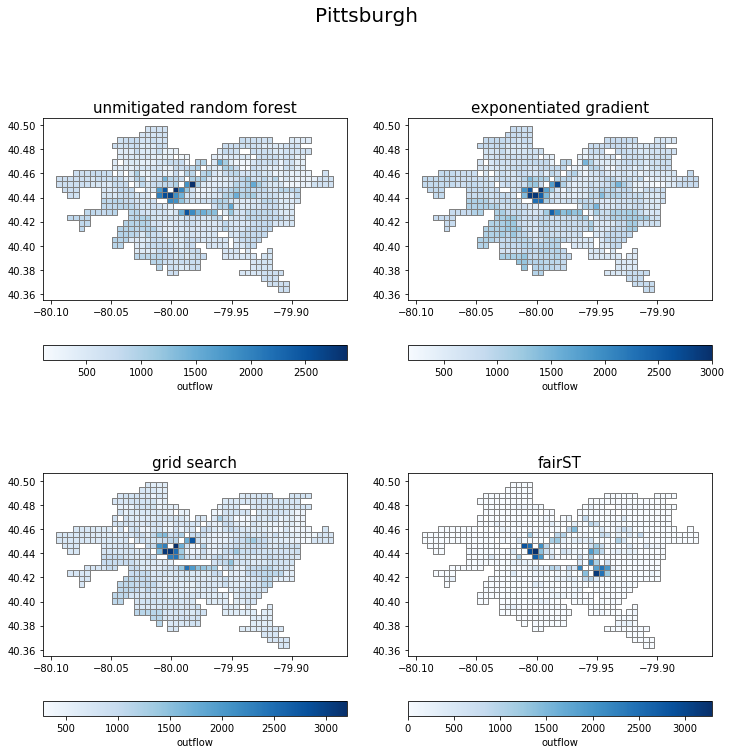

In [45]:
# grid search
fig, axes = plt.subplots(2,2, figsize = (12, 12))

ax1=axes[0,0]
ax2=axes[0,1]
ax3=axes[1,0]
ax4=axes[1,1]

pred_df_yearly.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1)
ax1.set_title("unmitigated random forest", fontsize=15)

pred_df_yearly.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax2)
ax2.set_title("exponentiated gradient", fontsize=15)

pred_df_yearly.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3, )
ax3.set_title("grid search", fontsize=15)

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax4, )

ax4.set_title("fairST", fontsize=15)

fig.suptitle(('Pittsburgh'), fontsize=20)

FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

In [46]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

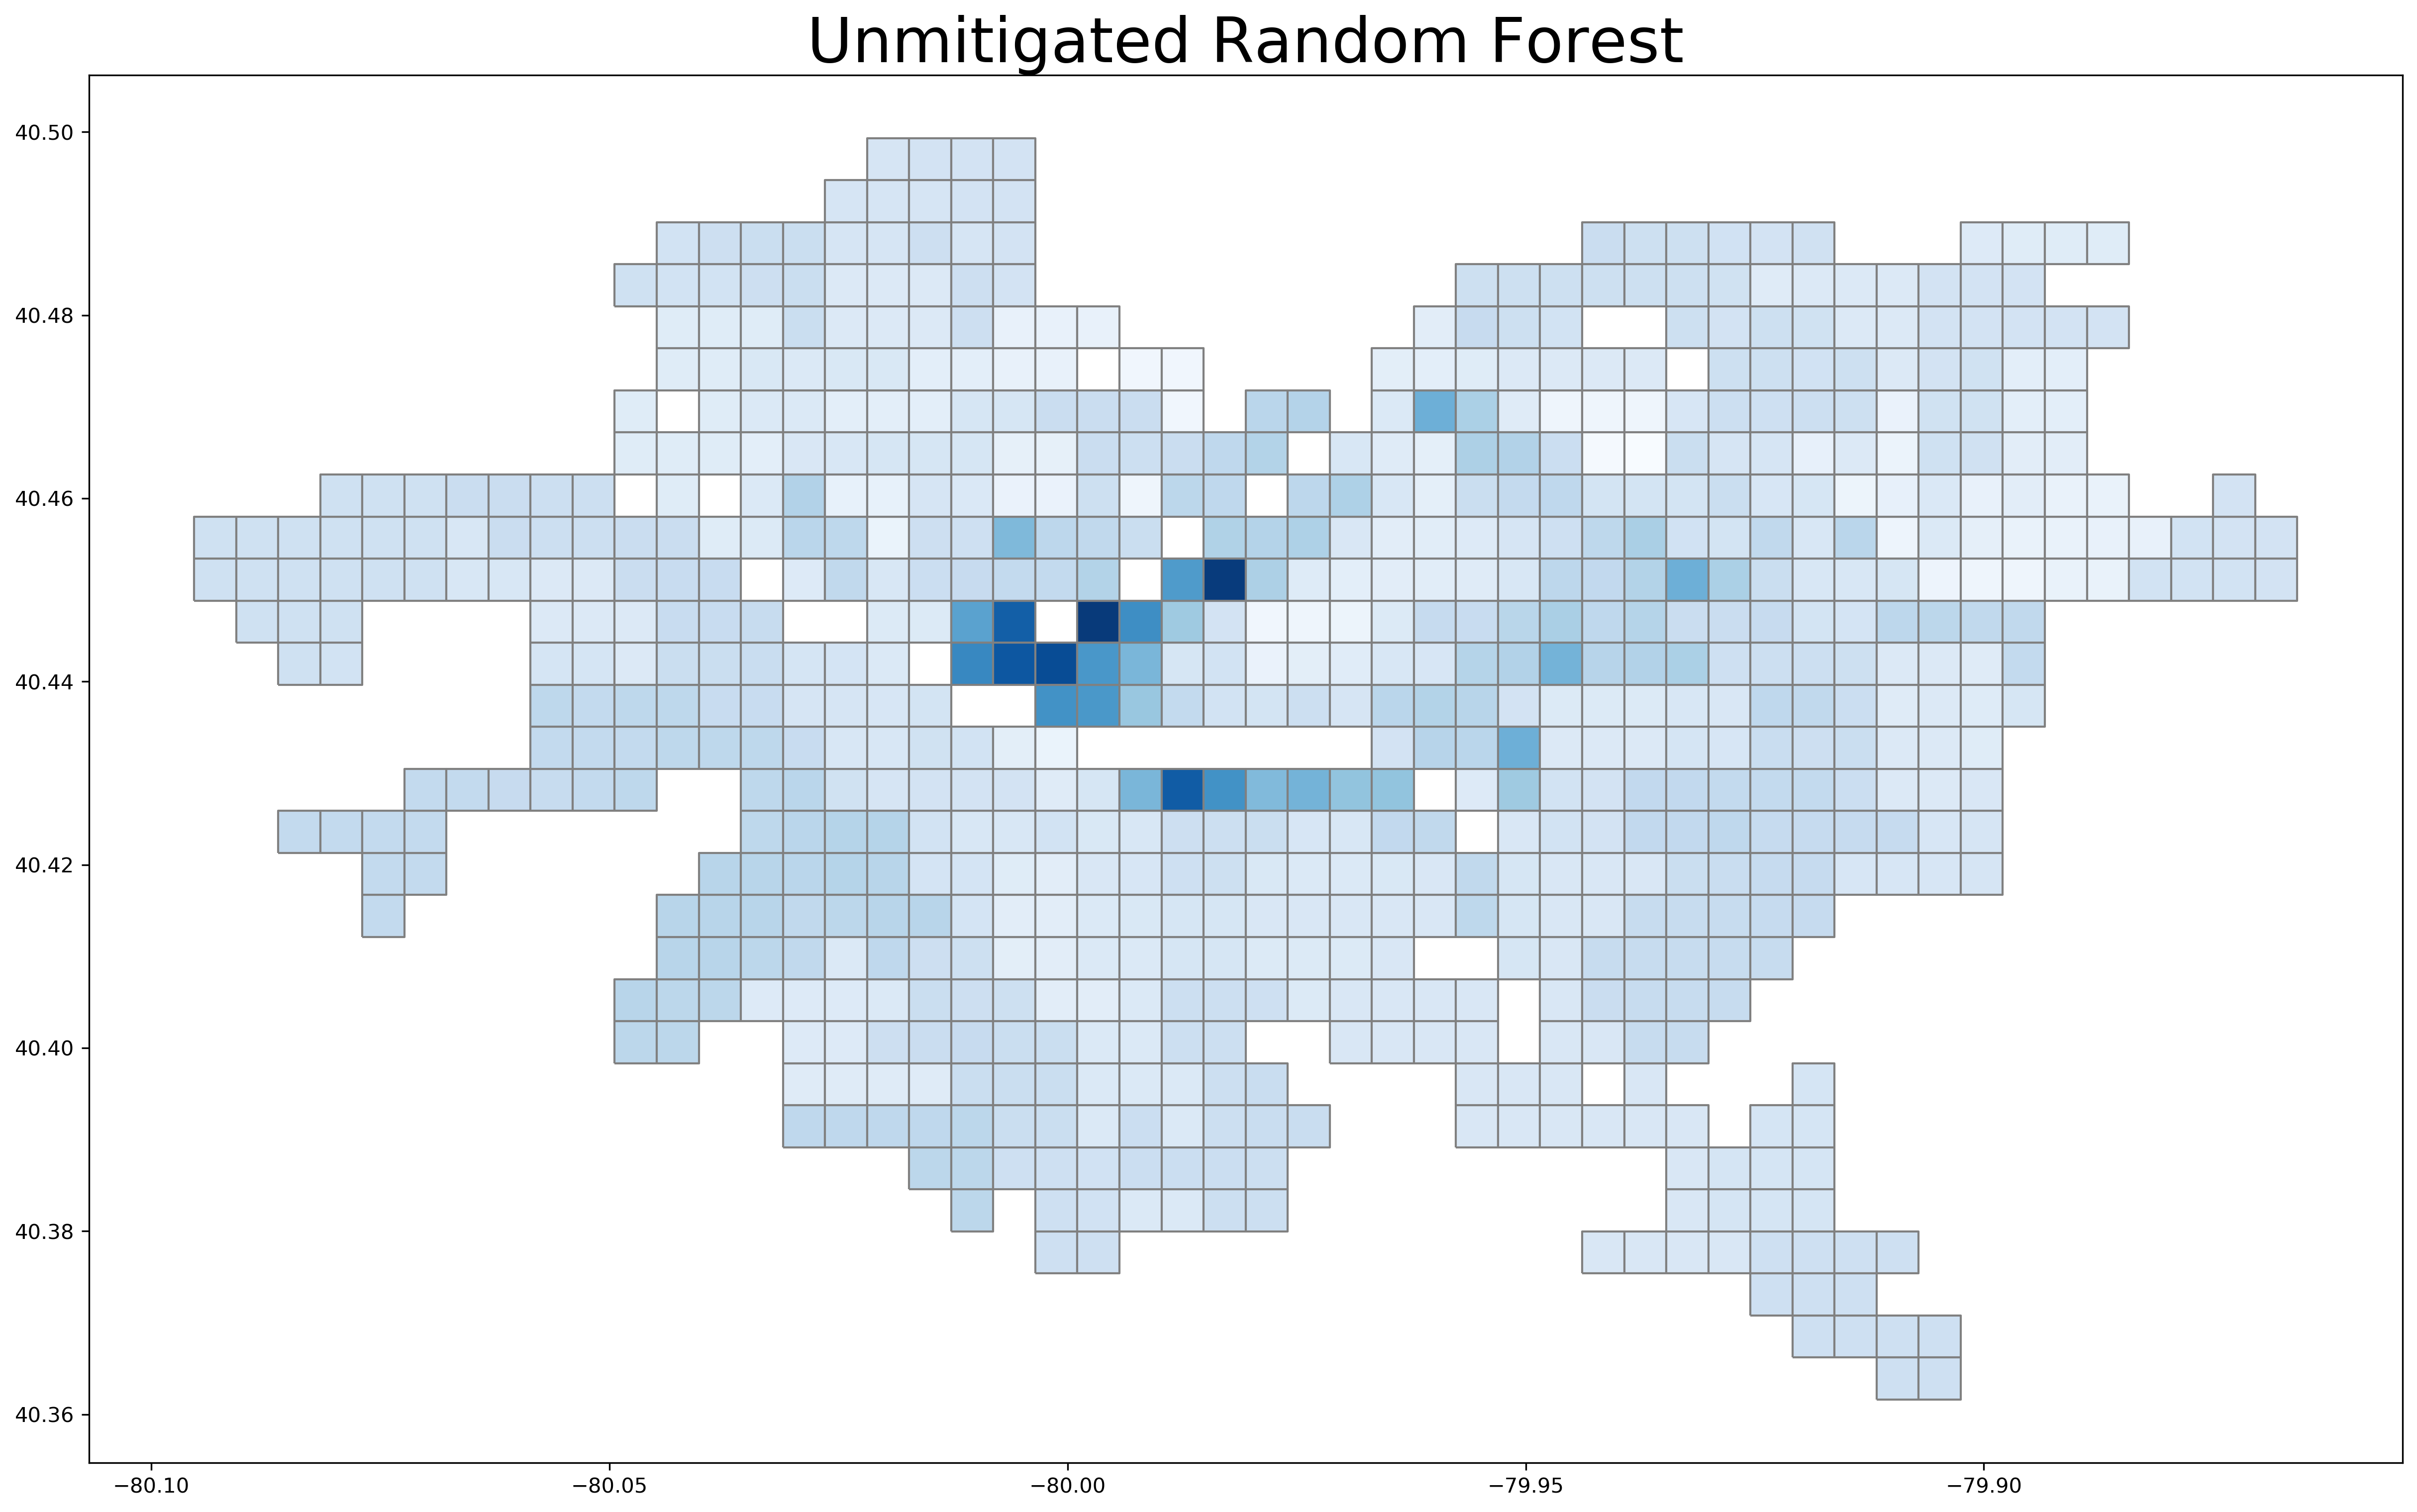

In [47]:
# plot 1
fig, axes = plt.subplots(figsize = (20, 16))
pred_df_yearly.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey",
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 3000)
axes.set_title("Unmitigated Random Forest", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_Unmitigated_" + CITY + FIG_NAME))

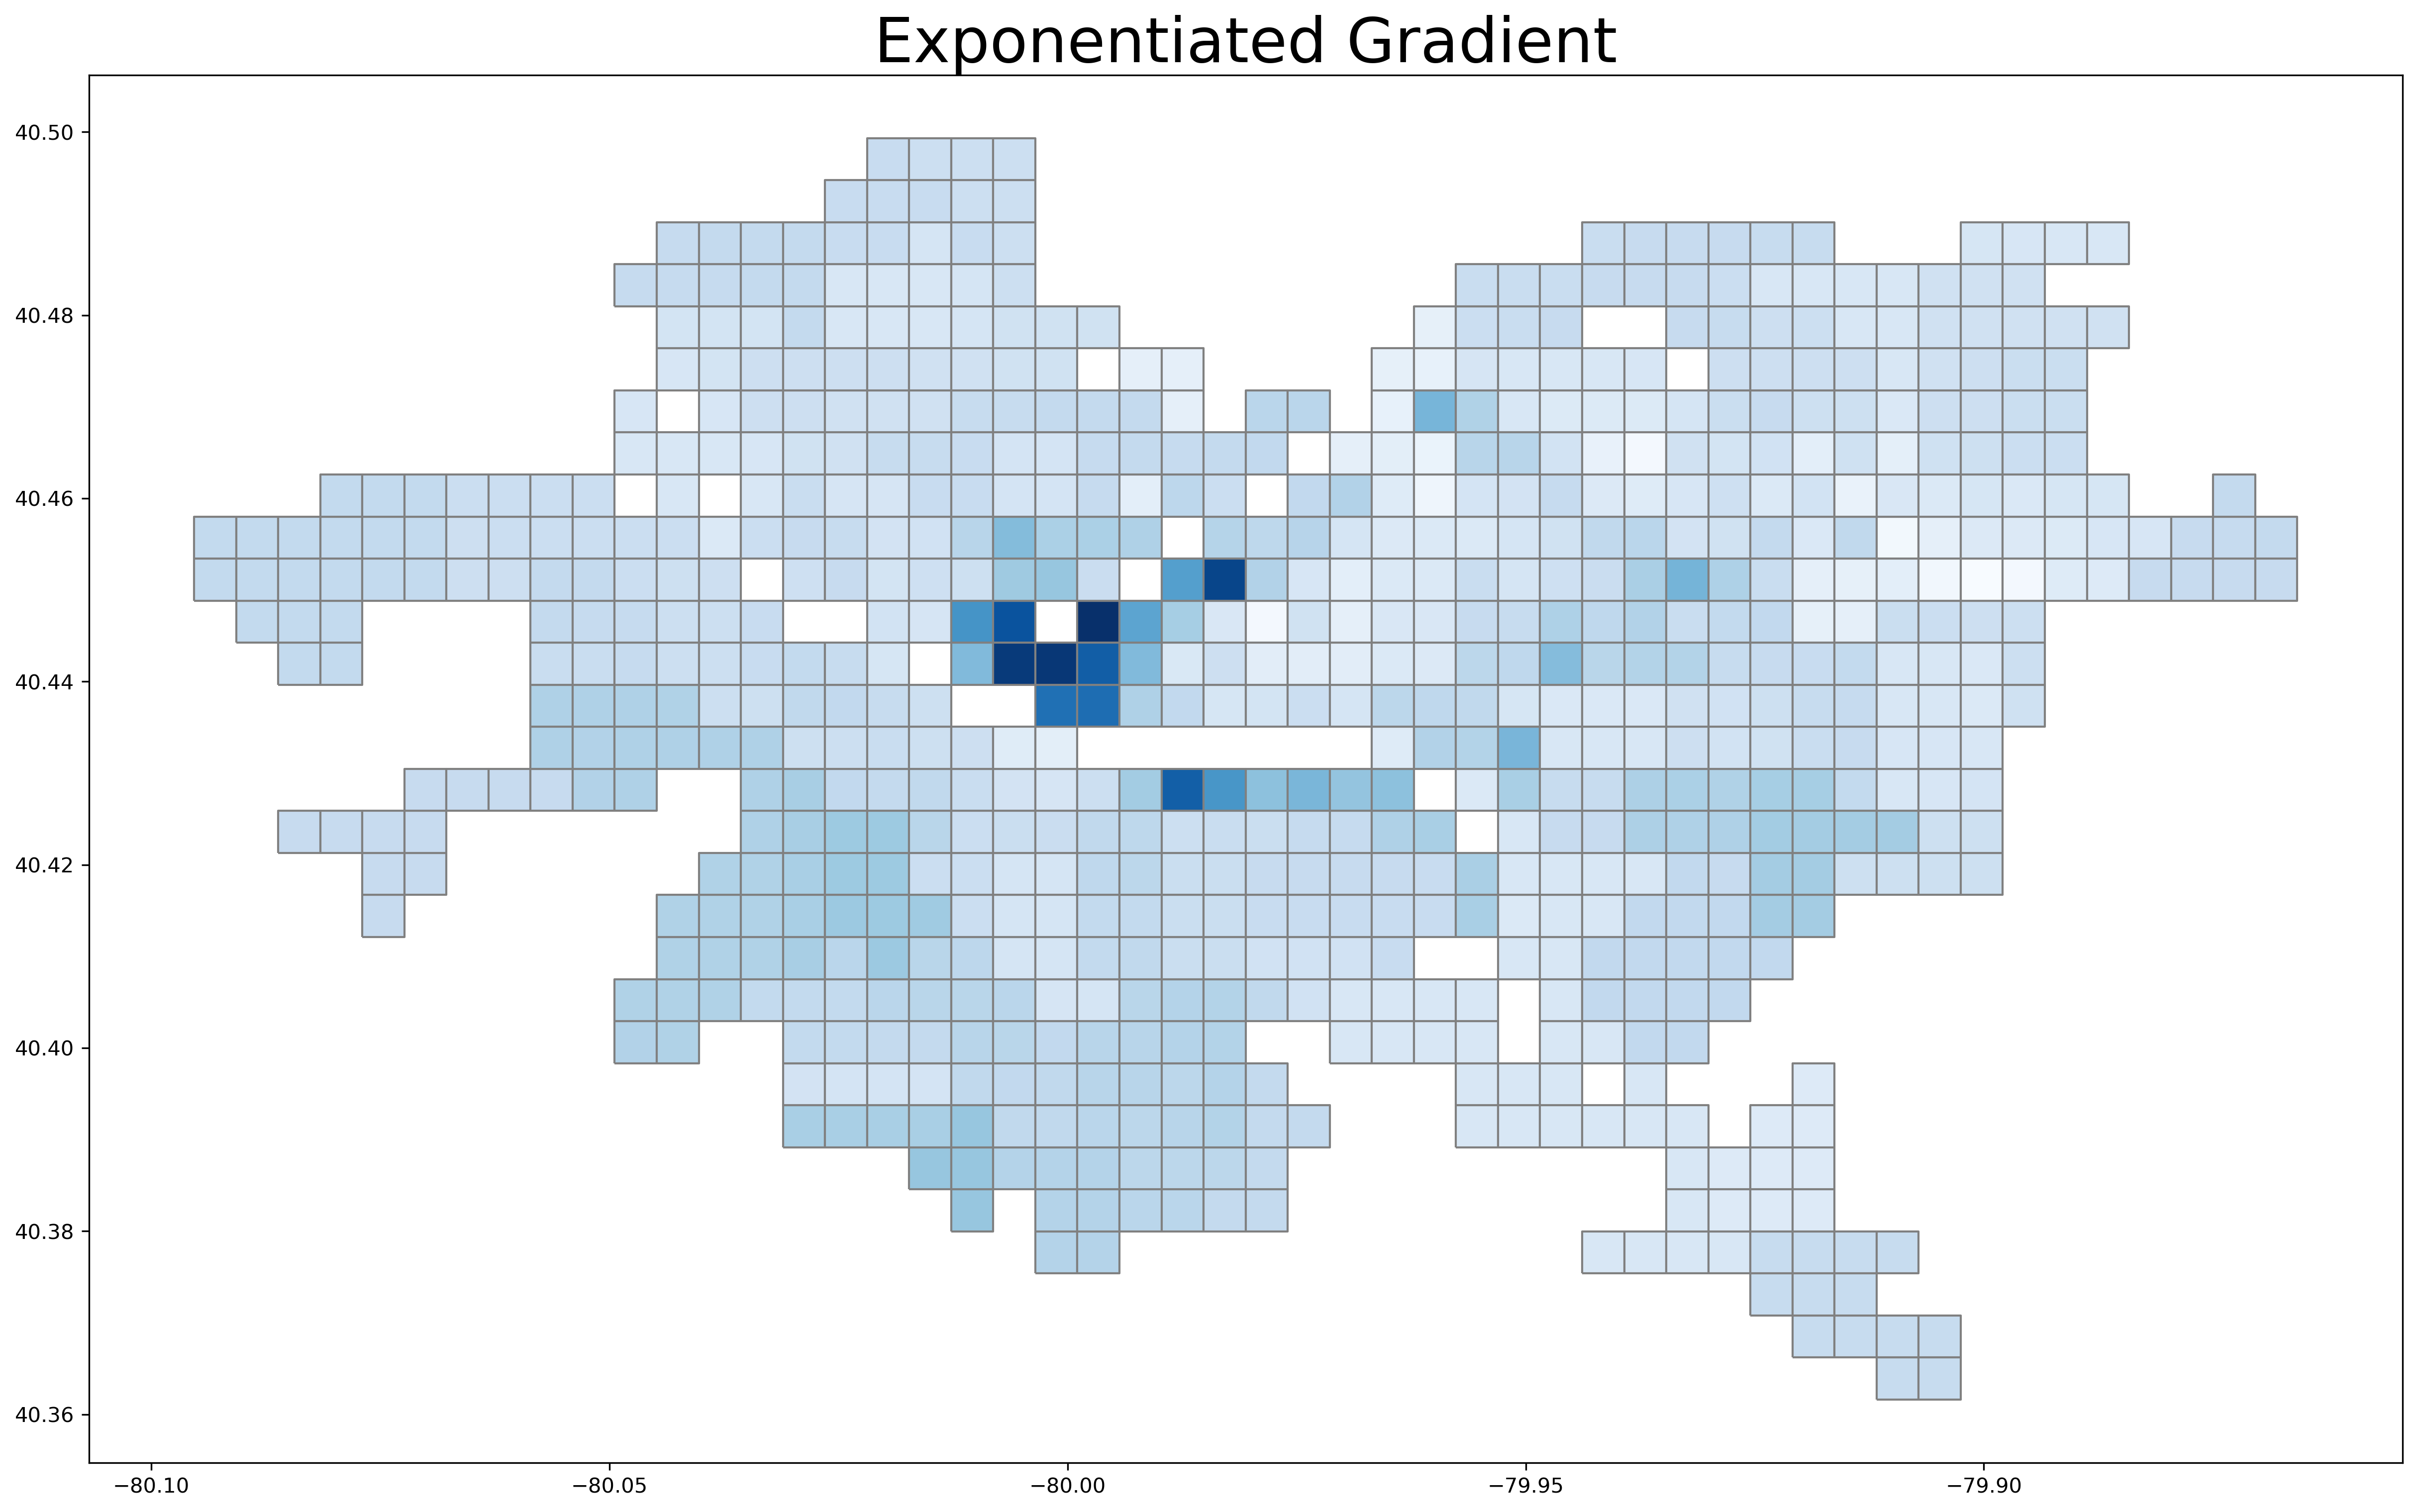

In [48]:
# plot 2
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 3000)
axes.set_title("Exponentiated Gradient", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_EG_" + CITY + FIG_NAME))

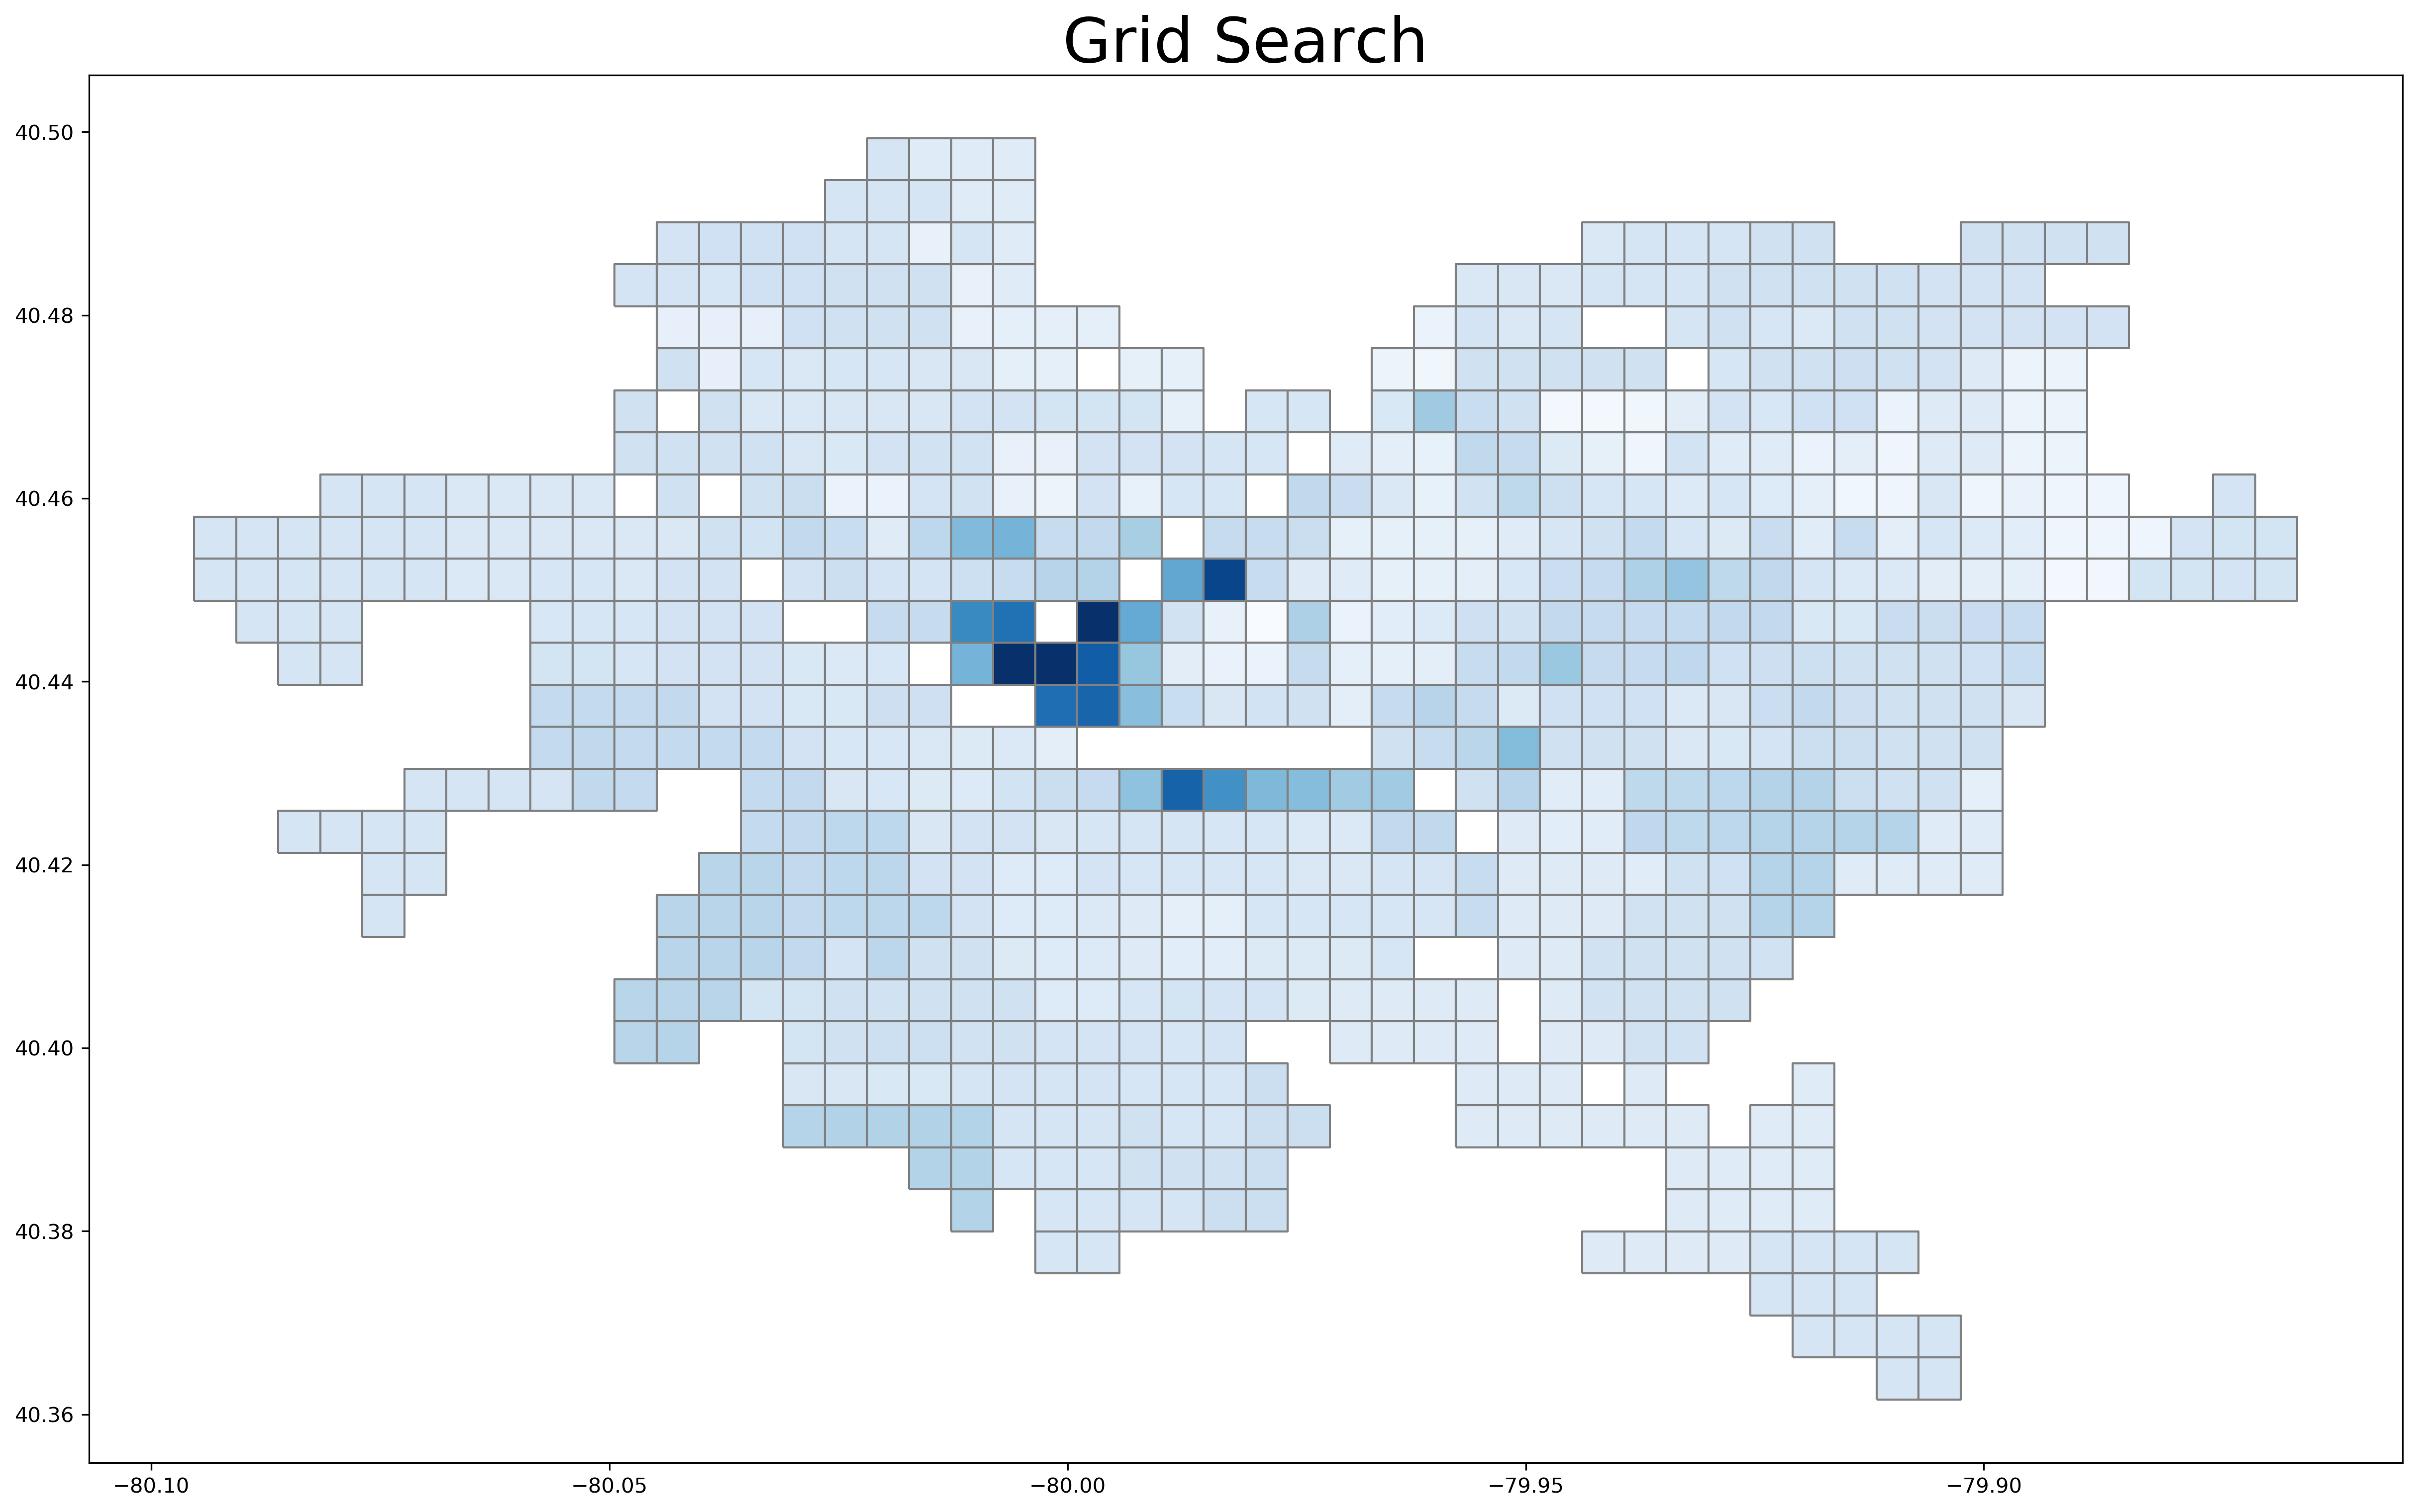

In [49]:
# plot 3
fig, axes = plt.subplots(figsize = (20, 16))

pred_df_yearly.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 3000)
axes.set_title("Grid Search", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_GS_" + CITY + FIG_NAME))

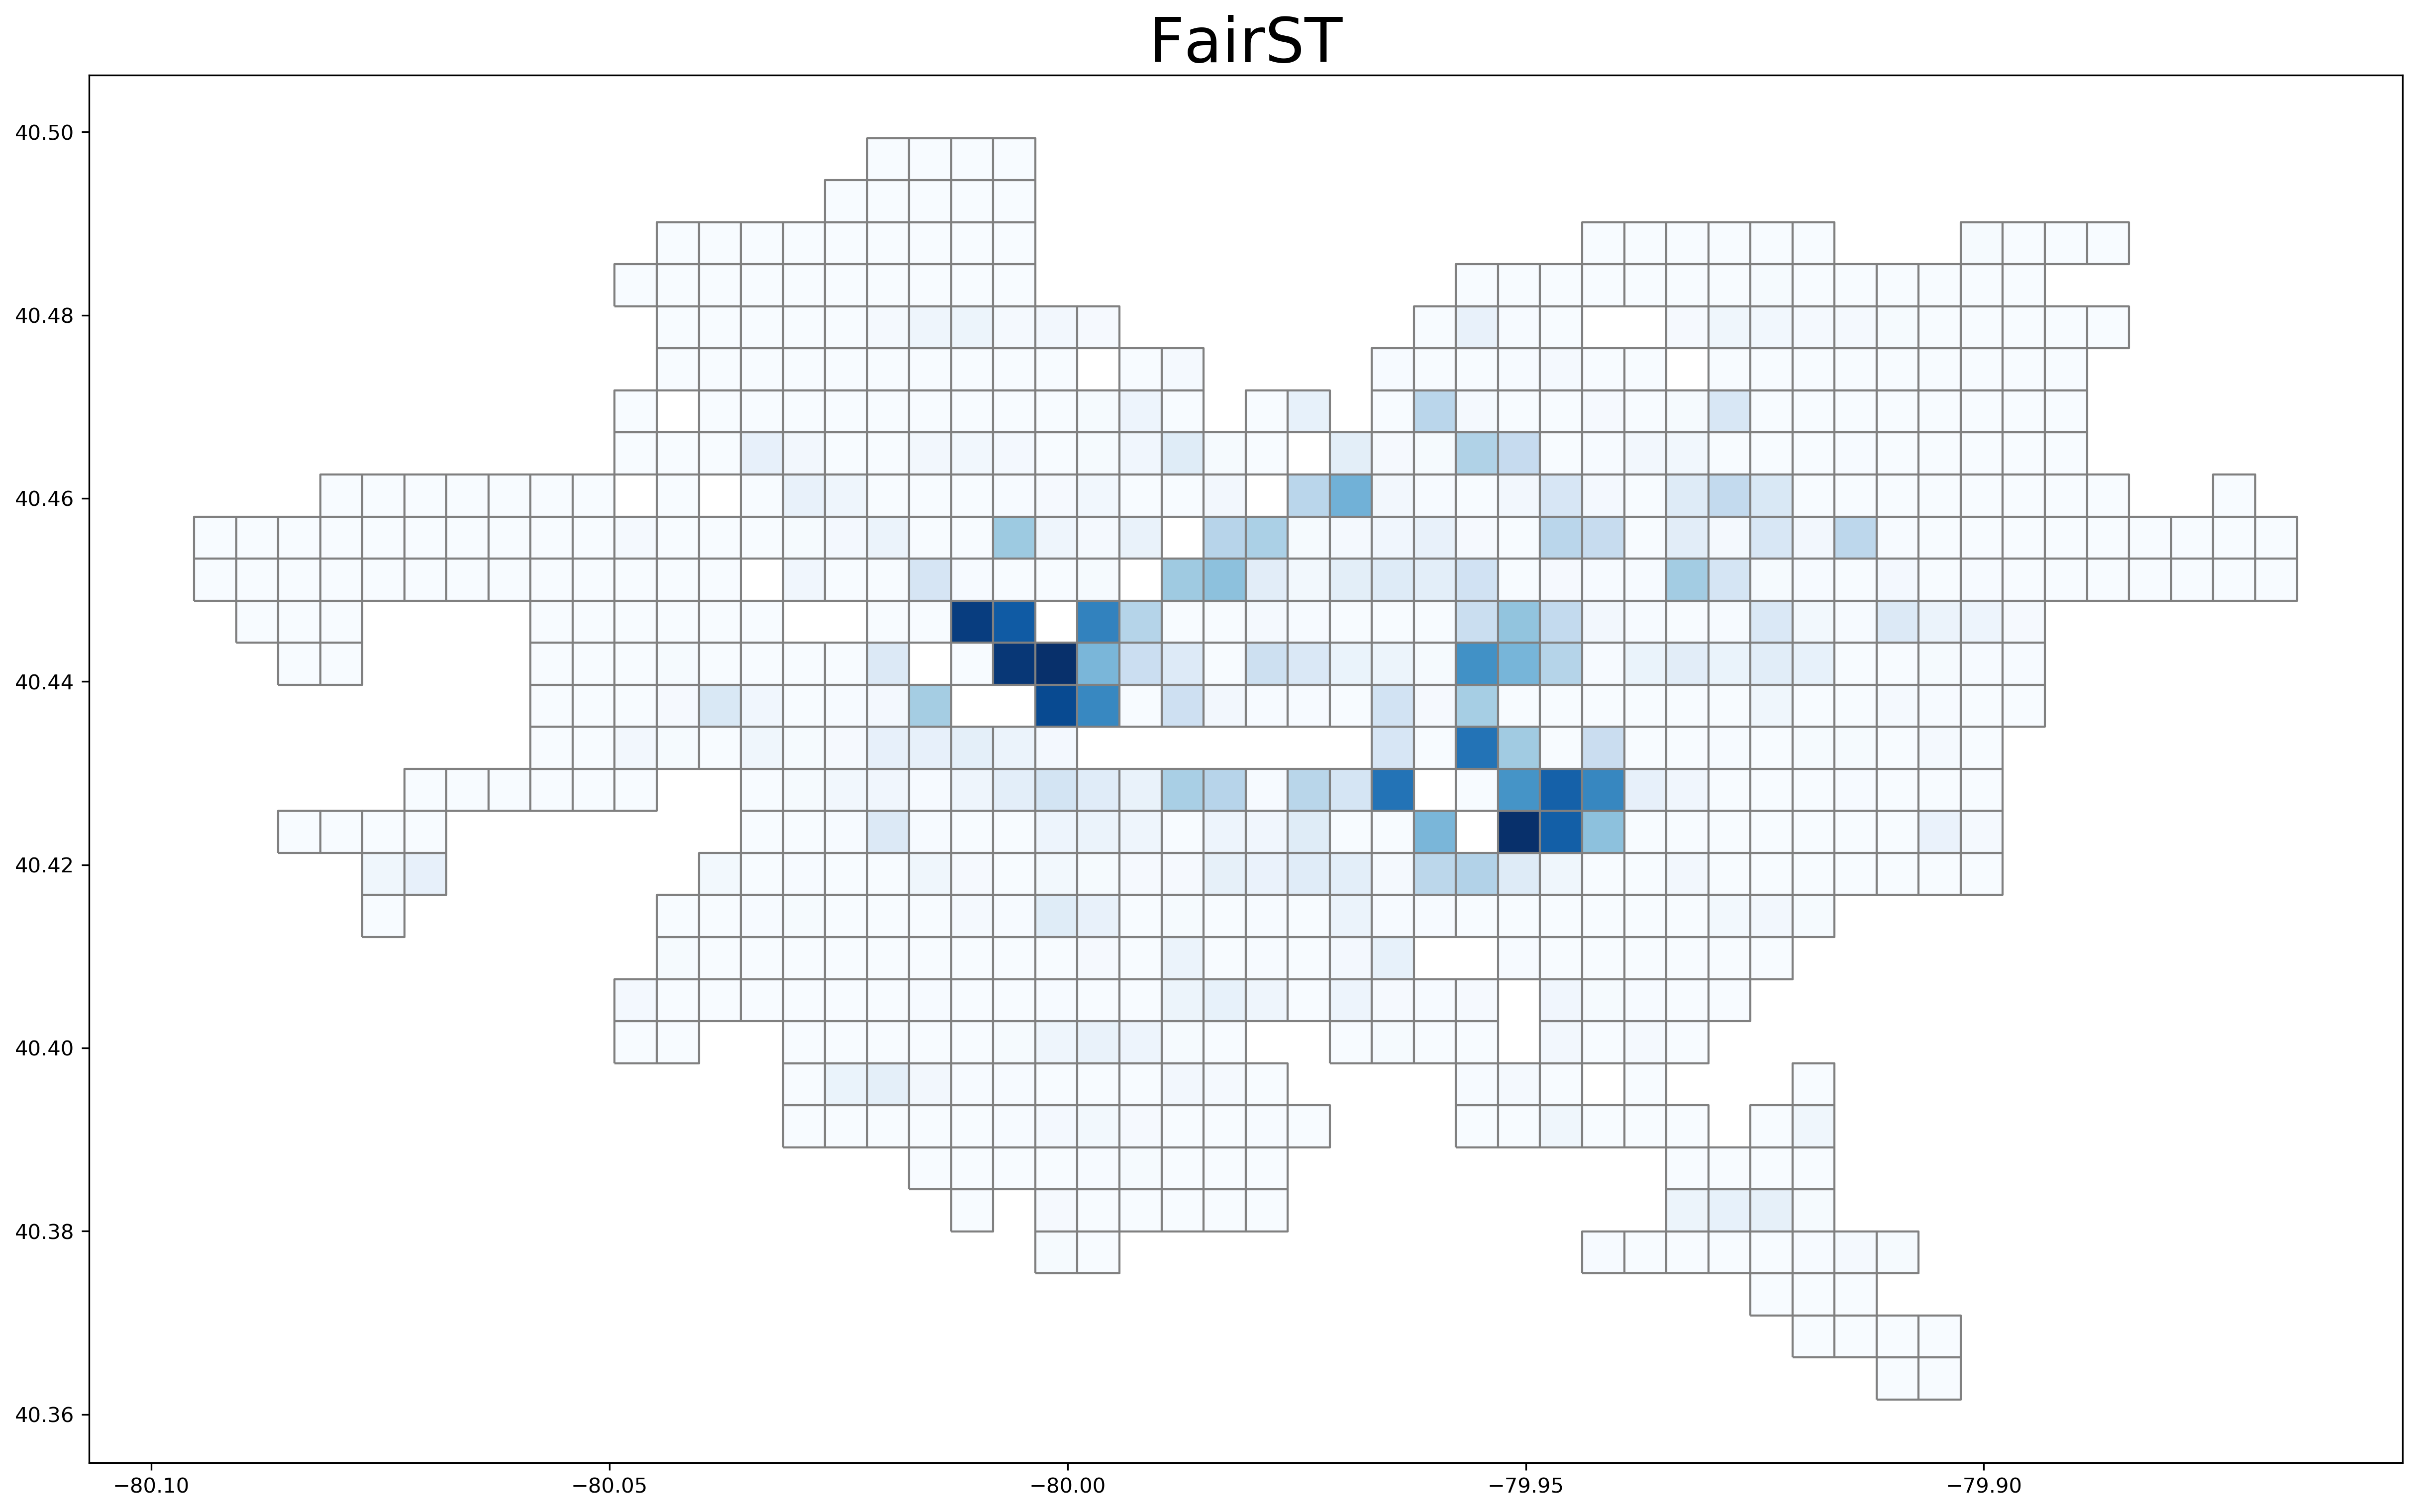

In [50]:
# plot 4
fig, axes = plt.subplots(figsize = (20, 16))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = False, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 3000)

axes.set_title("FairST", fontsize=30)
plt.savefig(os.path.join(save_dir_forecast, "FINAL_fairst_" + CITY + FIG_NAME))

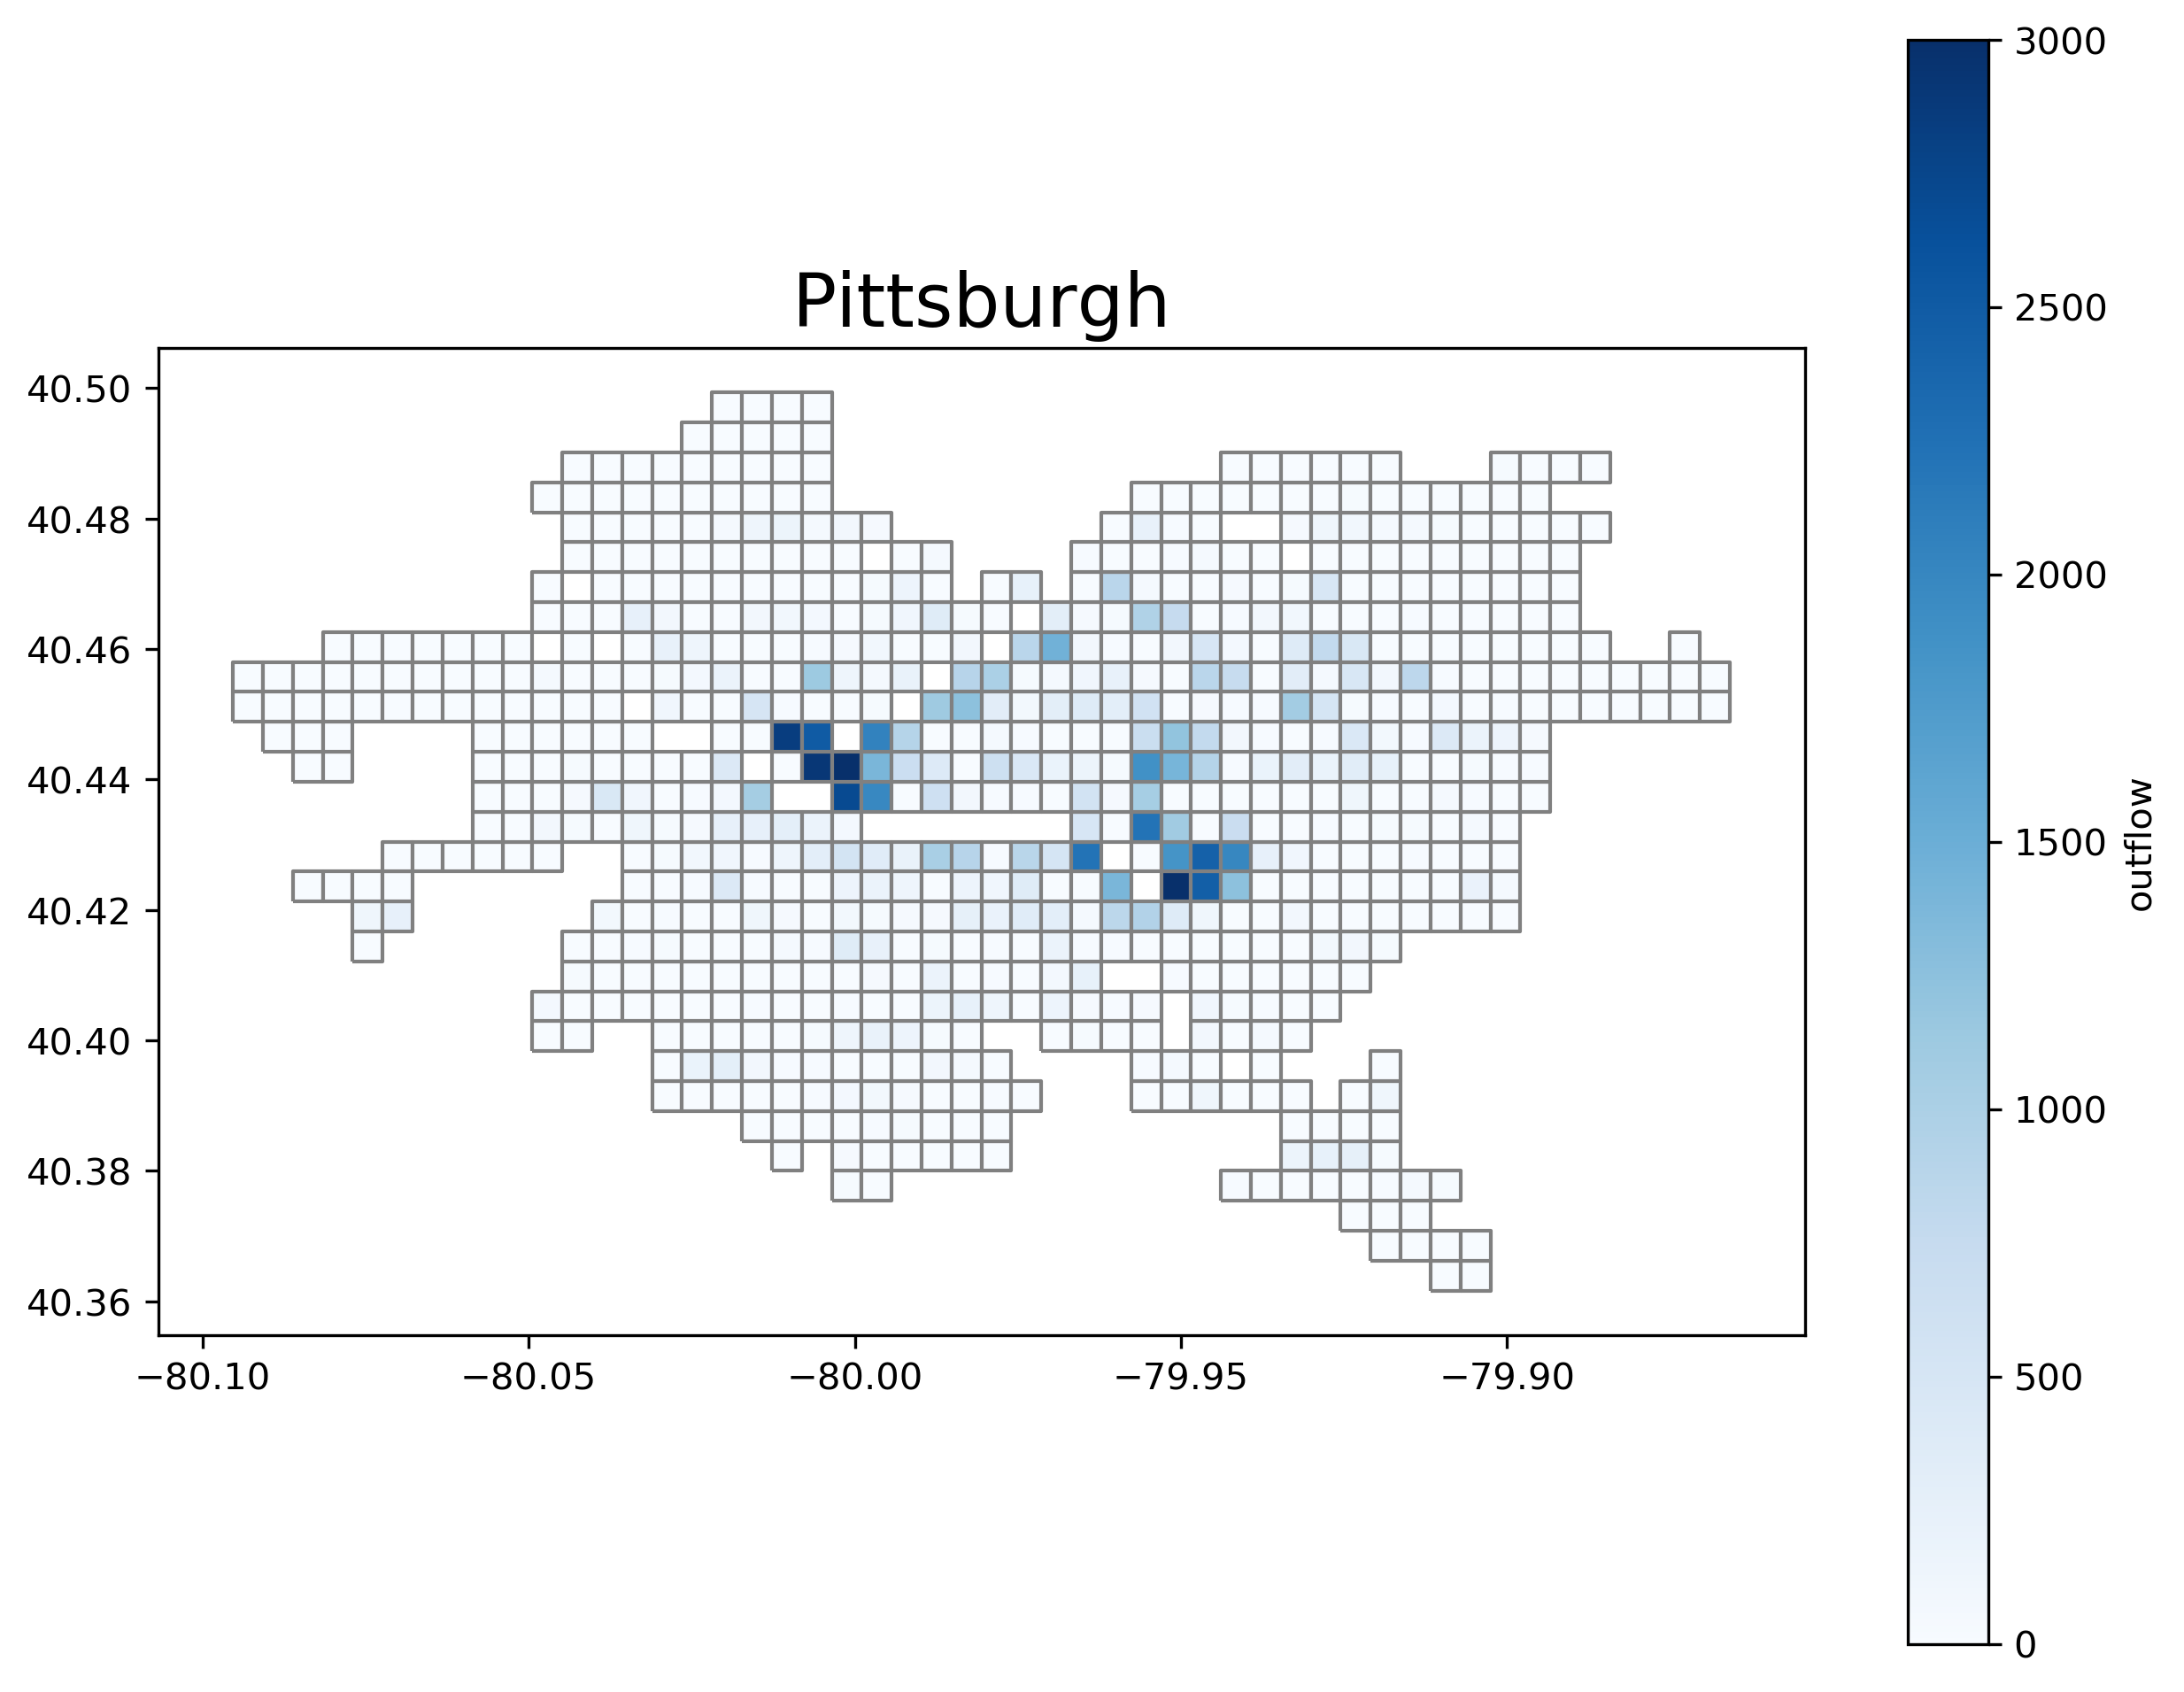

In [51]:
fig, axes = plt.subplots(figsize = (10, 8))

fairst_forecast_inc.plot(column="outflow", cmap='Blues',edgecolor = "grey", figsize=(12, 10),  
                    legend = True, legend_kwds={'label': "outflow",'orientation': "vertical"}, ax = axes, vmax = 3000)
axes.set_title("Pittsburgh", fontsize=20)
plt.savefig(os.path.join(save_dir_forecast, "color_bar"))

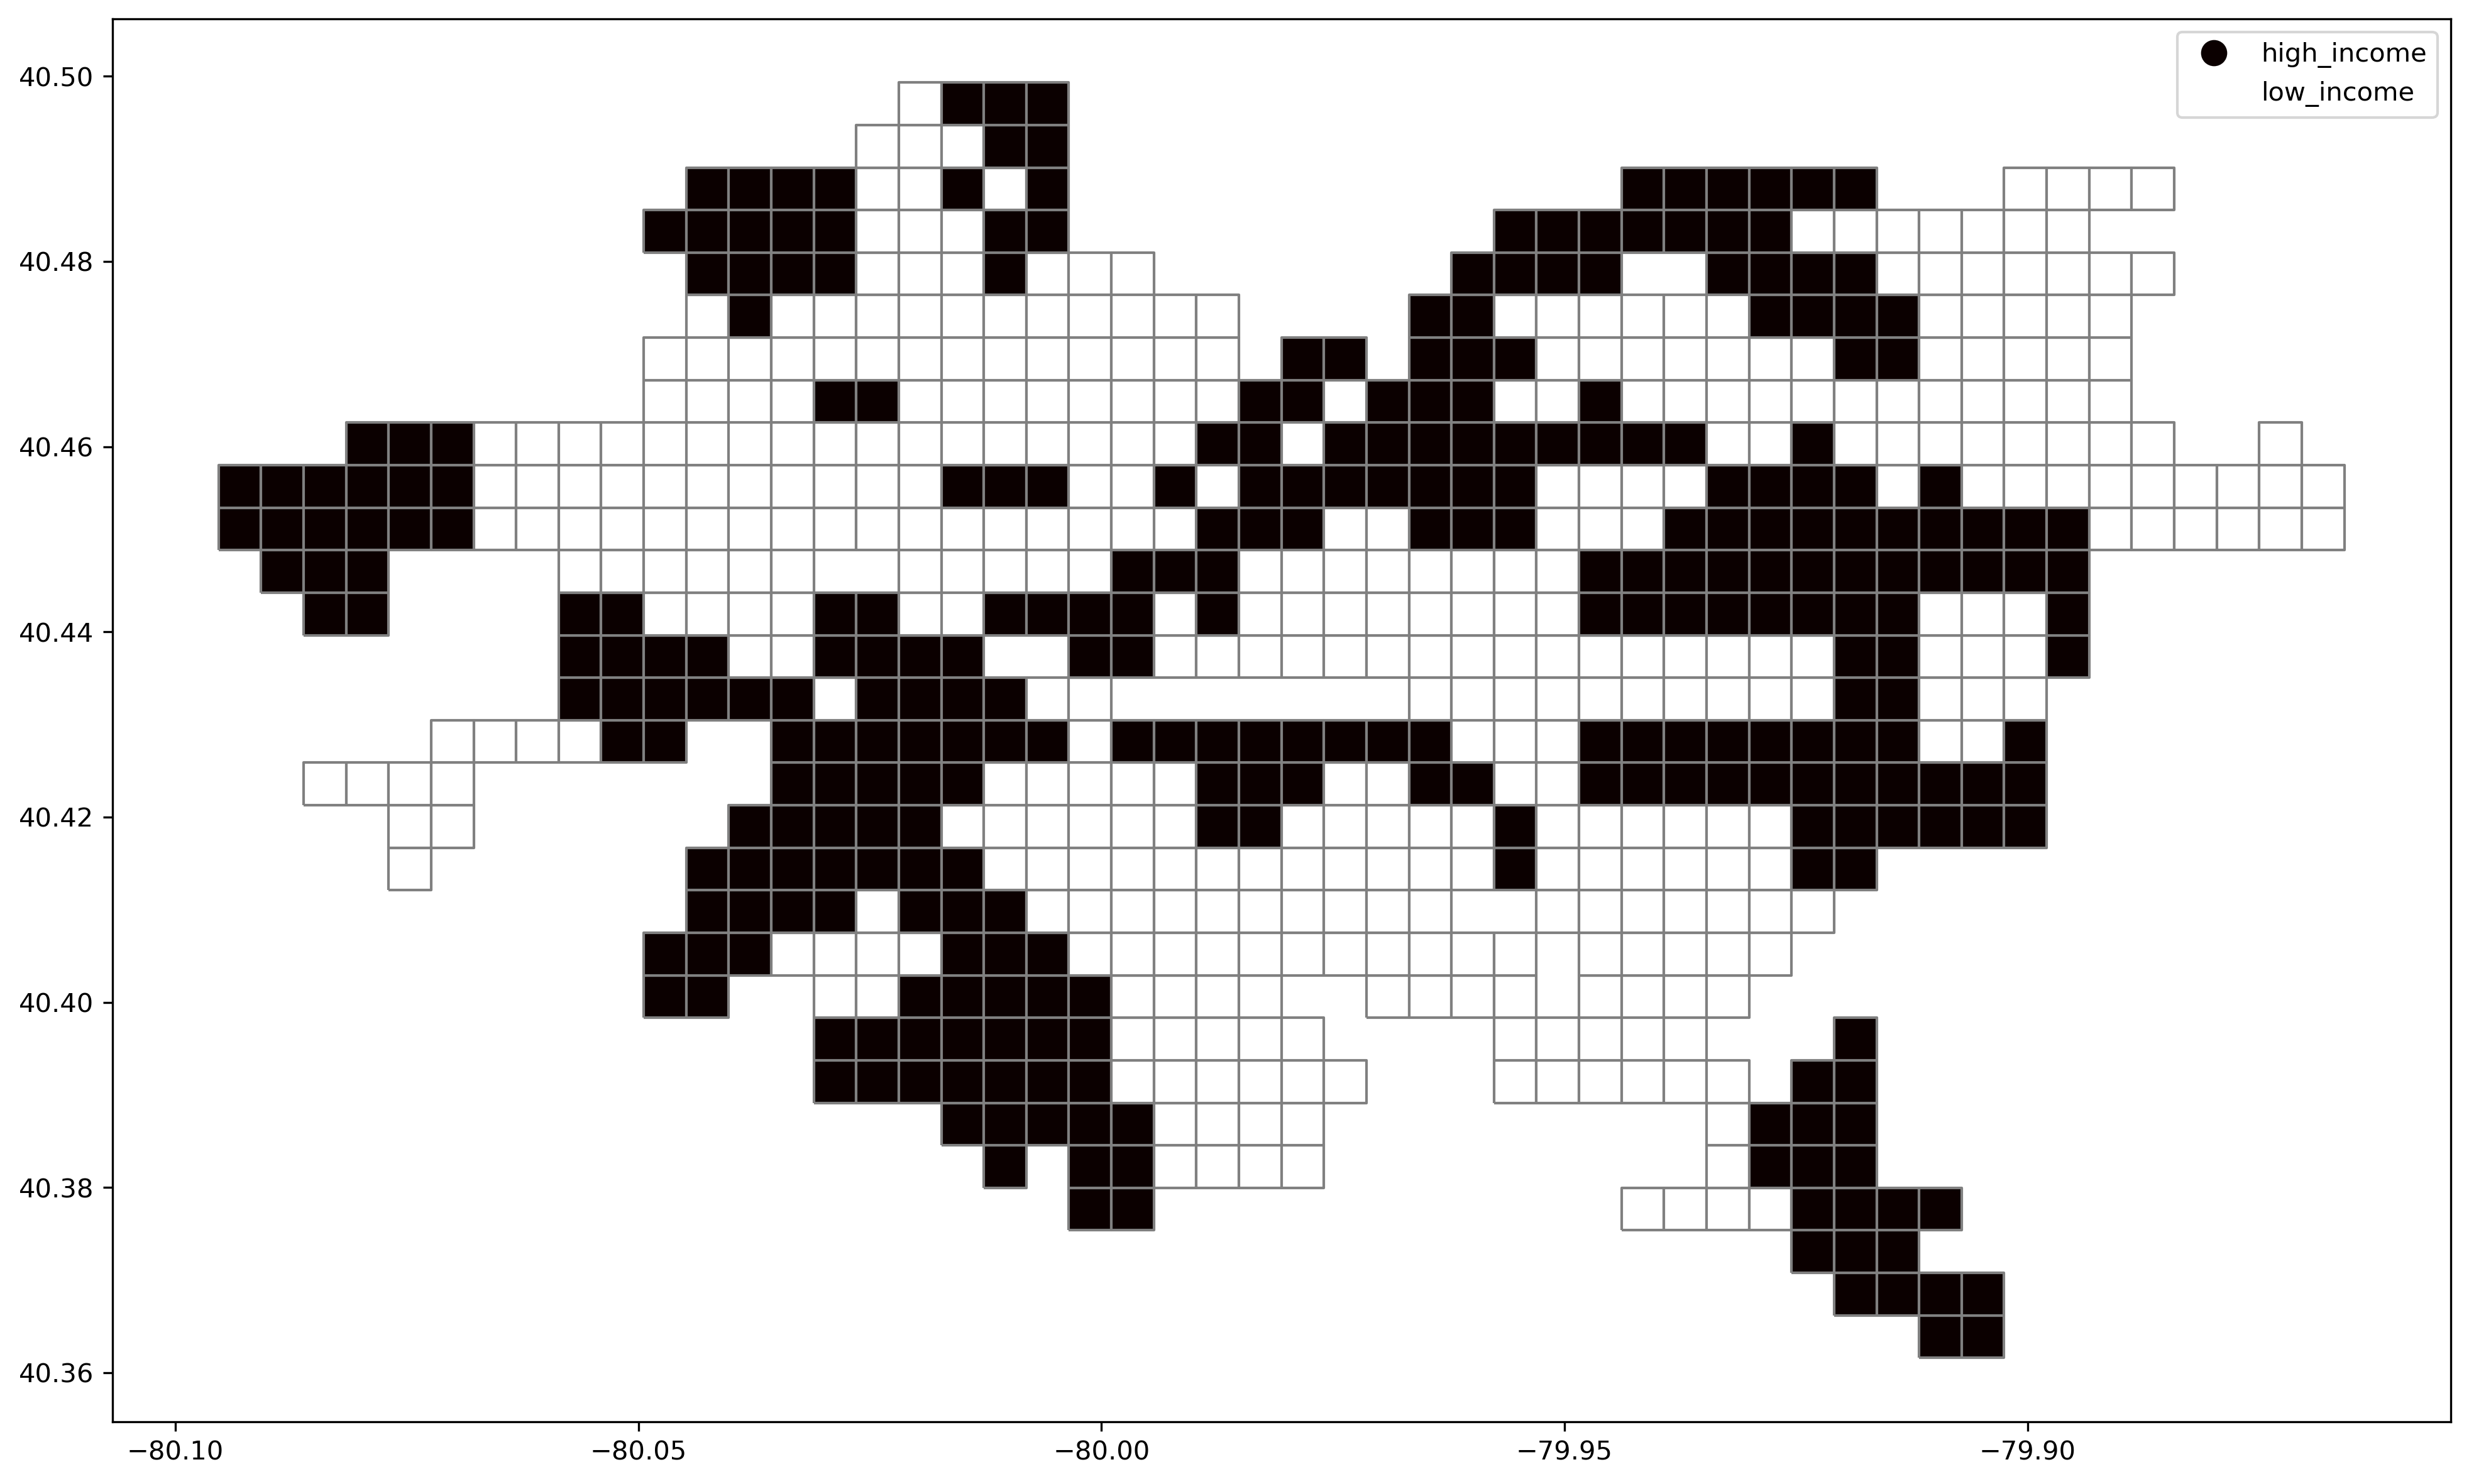

In [55]:
fig, axes = plt.subplots(figsize = (16, 12))
pred_df_yearly.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
                    legend = True, categorical = True, ax = axes)
# axes.set_title("Pittsburgh", fontsize=25)
FIG_NAME = "income_group_distribution"
plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))
plt.savefig("pitt_income_all")

In [47]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_df_yearly.plot(column="new_pred_random_forest", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1)
# ax1.set_title("unmitigated random forest", fontsize=15)

# pred_df_yearly.plot(column="new_pred_exp_grad", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"},  ax = ax2)
# ax2.set_title("exponentiated gradient", fontsize=15)

# pred_df_yearly.plot(column="new_pred_grid_search", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3)
# ax3.set_title("grid search", fontsize=15)


# df_income.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)

# fig.suptitle(('Visualisation of outflow forecast for 3 models\n after increase {} station').format(NUM_STATIONS_INC), fontsize=20)

# FIG_NAME = ("fig_after_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

In [48]:
# # grid search
# fig, axes = plt.subplots(2,2, figsize = (12, 12))

# ax1=axes[0,0]
# ax2=axes[0,1]
# ax3=axes[1,0]
# ax4=axes[1,1]

# pred_random_forest_geo.plot(column="random_forest_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax1)
# ax1.set_title("unmitigated random forest", fontsize=15)

# pred_exp_grad_geo.plot(column="exp_grad_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax2)
# ax2.set_title("exponentiated gradient", fontsize=15)

# pred_grid_search_geo.plot(column="grid_search_pred_diff", cmap='Blues',edgecolor = "grey", figsize=(8, 10),  
#                     legend = True, legend_kwds={'label': "outflow",'orientation': "horizontal"}, ax = ax3)
# ax3.set_title("grid search", fontsize=15)

# df_income.plot(column="income_group", cmap='hot', edgecolor = "grey", figsize=(2, 2),  
#                     legend = True, categorical = True, ax = ax4)
# ax4.set_title("income groups distribution", fontsize=15)

# fig.suptitle(('Visualisation of outflow forecast for 3 models\n difference for increase {} station').format(NUM_STATIONS_INC), fontsize=20)

# FIG_NAME = ("fig_diff_inc_{}_station").format(NUM_STATIONS_INC)
# plt.savefig(os.path.join(save_dir_forecast, CITY + FIG_NAME))

### Analysis 3: difference in increase between two income groups

In [49]:
# def forecast_res_calc(pred_year_df):
#     diff_col = pred_year_df.columns[-3]
#     # print(diff_col)
    
#     high_inc = pred_year_df[pred_year_df["bi_income"] == "high_income"]
#     high_inc_sum_diff = (high_inc[diff_col] / high_inc["stations_added"]).sum()
#     high_inc_sum_diff_avg = high_inc_sum_diff/len(high_inc)
    
#     low_inc = pred_year_df[pred_year_df["bi_income"] == "low_income"]
#     low_inc_sum_diff = (low_inc[diff_col] / low_inc["stations_added"]).sum()
#     low_inc_sum_diff_avg = low_inc_sum_diff/len(low_inc)
    
# #     print(high_inc_sum_diff_avg)
# #     print(low_inc_sum_diff_avg)
#     diff = high_inc_sum_diff_avg - low_inc_sum_diff_avg
#     ratio = low_inc_sum_diff_avg / high_inc_sum_diff_avg
    
#     return high_inc_sum_diff_avg, low_inc_sum_diff_avg, diff, ratio

In [50]:
# forc_res_summary = pd.DataFrame(0, columns = ["high_inc_sum_diff_avg", "low_inc_sum_diff_avg","diff", "ratio"],
#                                    index = ["random_forest", "exp_grad", "grid_search"])

In [51]:
# forc_res_rf = forecast_res_calc(pred_random_forest_yearly)
# forc_res_eg = forecast_res_calc(pred_exp_grad_yearly)
# forc_res_gs = forecast_res_calc(pred_grid_search_yearly)

# forc_res_summary.loc["random_forest", "high_inc_sum_diff_avg"] = forc_res_rf[0]
# forc_res_summary.loc["random_forest", "low_inc_sum_diff_avg"] = forc_res_rf[1]
# forc_res_summary.loc["random_forest", "diff"] = forc_res_rf[2]
# forc_res_summary.loc["random_forest", "ratio"] = forc_res_rf[3]

# forc_res_summary.loc["exp_grad", "high_inc_sum_diff_avg"] = forc_res_eg[0]
# forc_res_summary.loc["exp_grad", "low_inc_sum_diff_avg"] = forc_res_eg[1]
# forc_res_summary.loc["exp_grad", "diff"] = forc_res_eg[2]
# forc_res_summary.loc["exp_grad", "ratio"] = forc_res_eg[3]

# forc_res_summary.loc["grid_search", "high_inc_sum_diff_avg"] = forc_res_gs[0]
# forc_res_summary.loc["grid_search", "low_inc_sum_diff_avg"] = forc_res_gs[1]
# forc_res_summary.loc["grid_search", "diff"] = forc_res_gs[2]
# forc_res_summary.loc["grid_search", "ratio"] = forc_res_gs[3]

In [52]:
# FILE_NAME = ("forc_res_summary_station_inc_{}.csv").format(NUM_STATIONS_INC)
# forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))
# forc_res_summary

___

In [53]:
def forecast_res_calc(pred_df_yearly_geo):
    
    high_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "high_income"]
    low_inc = pred_df_yearly_geo[pred_df_yearly_geo["income_group"] == "low_income"]

    random_forest_diff =  ((low_inc.new_pred_random_forest.sum())/len(low_inc)) / ((high_inc.new_pred_random_forest.sum())/len(high_inc))
    exp_grad_diff =  ((low_inc.new_pred_exp_grad.sum())/len(low_inc)) / ((high_inc.new_pred_exp_grad.sum())/len(high_inc))
    grid_search_diff =  ((low_inc.new_pred_grid_search.sum())/len(low_inc)) / ((high_inc.new_pred_grid_search.sum())/len(high_inc))

    return random_forest_diff, exp_grad_diff, grid_search_diff

In [54]:
FILE_NAME = "forc_res_summary.csv"

PATH1 = os.path.join(save_dir_forecast, CITY + FILE_NAME)

if path.exists(PATH1):
    forc_res_summary = pd.read_csv(PATH1, index_col = 0)
else:
    forc_res_summary = pd.DataFrame(0, columns = ["random_forest_ratio", "exp_grad_ratio", "grid_search_ratio"], index = ["inc_{}_station".format(NUM_STATIONS_INC)])

In [55]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "random_forest_ratio"] = forecast_res_calc(pred_df_yearly)[0]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "exp_grad_ratio"] = forecast_res_calc(pred_df_yearly)[1]
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "grid_search_ratio"] = forecast_res_calc(pred_df_yearly)[2]

In [56]:
fairst_high_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 1]
fairst_low_inc = fairst_forecast_inc[fairst_forecast_inc["income_group"] == 0]
fairst_high_inc_avg = ((fairst_high_inc.outflow.sum())/len(fairst_high_inc))
fairst_low_inc_avg = ((fairst_low_inc.outflow.sum())/len(fairst_low_inc))

fairst_ratio = fairst_low_inc_avg/fairst_high_inc_avg

In [57]:
forc_res_summary.loc["inc_{}_station".format(NUM_STATIONS_INC), "fairst_ratio"] = fairst_ratio

In [64]:
forc_res_summary.to_csv(os.path.join(save_dir_forecast, CITY + FILE_NAME))